In [1]:
from rich.pretty import pprint

def pretty_print(title: str = None, content: str = None):
    if title is None:
        print(content)
        return
    print(title)
    pprint(content)

## Image for use

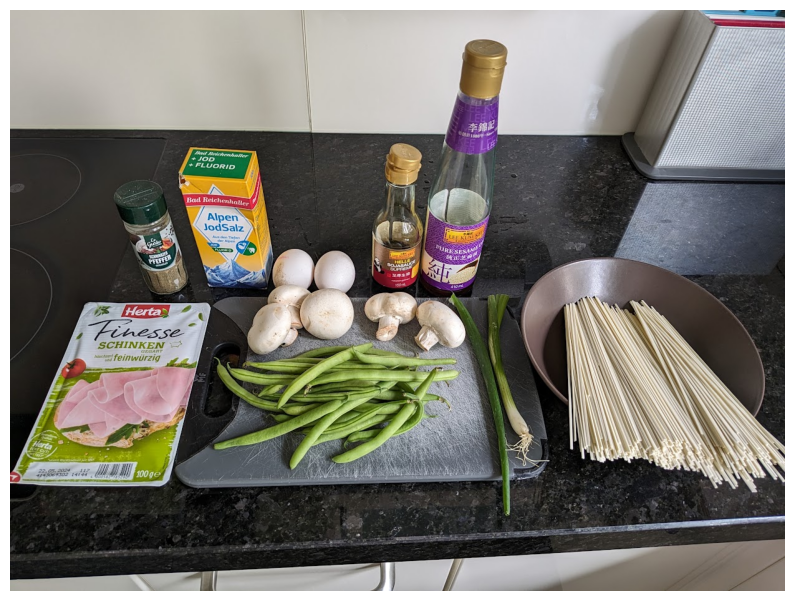

In [2]:
import matplotlib.pyplot as plt

image_path = "tmp/PXL_20240519_091911801.jpg"
import urllib.request

url = "https://dl.dropbox.com/scl/fi/fvpgpwzlqa8v3j6ntis2s/PXL_20240519_091911801.jpg?rlkey=vtc5dakept5jku8klknfaa150"
urllib.request.urlretrieve(url, image_path)

# no axis
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(image_path))

## Method

- Use the multi-modal model to create a row of accurate ground truth labels, known as `gt`, for object detection in the image.
    - Use the multi-modal model to generate a detailed description of the image.
    - Use the multi-modal model to derive object labels from the image description, utilizing a COCO dataset label for standard.
- To enhance the dynamic power of the multi-model in generating varied image descriptions, we raise the model's `temperature`.
- Use the `gt` to occhastrate the open-vocabulary models to detect objects in the image.
- Because the open-vocabulary models can only detect the objects that the `gt` has identified, we employ the proper metircs to compare the performance of the open-vocabulary models with the `gt`.
- We perform serveral above steps repeatedly, denoting `N_repeats`, so `N_repeat` groups of `gt` and run the open-vocabulary models on each group.

## Metrics

We employ a multi-modal model to ochastrate an open-vocabulary models for object detection to compare the performance of those.

The open-vocabulary models depend on the multi-modal model to first detect objects. In order to evaluate the performance of the open-vocabulary models, we assess its accuracy by comparing the percentage of detections from the ground truth (`gt`) determined by the multi-modal model with the predictions (`pred`) generated by the open-vocabulary models.

In [3]:
class Metrics:
    gt: list[str]
    pred: list[str]

    def __init__(self, gt: list[str], pred: list[str]):
        self.gt = set(gt)
        self.pred = set(pred)

        #pretty_print("Ground truth", self.gt)
        #pretty_print("Prediction", self.pred)

    def accuracy(self) -> float:
        acc = len(self.pred.intersection(self.gt)) / len(self.gt)
        return round(acc, 3)

    @property
    def __str__(self) -> str:
        return f"Accuracy: {self.accuracy()}"

## Generate the ground truth labels

- GPT-4o: Generate the image description, also `Anthropic` can be a good choice.
- GPT-3.5: Generate the labels based on the image description, COCO format.

In [4]:
N_repeats = 100
temperature = 0.8

In [5]:
# If no keys to OpenAI or other providers, just try the following labels.

# coco_labels = [
# 'food, fruit, vegetable, bowl, knife, cutting board, kitchen, countertop',
# │   'packet, ham, countertop',
# │   'packet, container, pepper',
# │   'carton,salt,pepper\tcontainer',
# │   'mushroom,cutting board',
# │   'mushroom, egg, cutting board',
# │   'vegetable, food, green beans, mushrooms, cutting board',
# │   'vegetable, onion, green, cutting board, green beans',
# │   'bottle, label, cap',
# │   'bottle, oil, label, cap',
# │   'bowl,noodles',
# │   'countertop,kitchen,cabinets,stovetop',
# │   'cutting board, rectangle, plastic',
# │   'food,dish,bowl,noodles,spaghetti,soba,udon',
# │   'container,lid,text',
# │   'container, text, blue, white, yellow, red',
# │   'food, meat, herb',
# │   'bottle,label,red,gold,Asian_characters',
# │   'bottle, cap, label',
# │   'mushroom',
# │   'vegetable, food, green bean',
# │   'vegetable, plant, green onion',
# │   'bowl, surface',
# │   'egg,cutting board',
# │   'countertop, surface, light',
# │   'indoor, wall, kitchen',
# │   'stove, cooktop',
# │   'bottle,sauce',
# │   'food, bowl, plate, table',
# │   'cutting board, vegetables, mushrooms',
# │   'food, ham',
# │   'vegetable, food, green bean',
# │   'egg',
# │   'kitchen, ingredients',
# │   'mushroom',
# │   'plant, vegetable, food',
# │   'bottle, liquid',
# │   'bottle,oil',
# │   'countertop, white, backsplash',
# │   'cutting board, texture, plastic',
# │   'food,dish,bowl',
# │   'container, pepper',
# │   'container,bottle',
# │   'window, indoor',
# │   'kitchen, clutter',
# │   'food, ham, packet, window, slices',
# │   'green beans, vegetables',
# │   'mushroom',
# │   'vegetable, onion, cutting board',
# │   'egg',
# │   'bowl,noodles',
# │   'countertop, surface',
# │   'bottle,label,English,Asian',
# │   'bottle, label',
# │   'food, packet, ham',
# │   'vegetable, food',
# │   'mushroom',
# │   'plant,onion',
# │   'egg,cutting board',
# │   'cutting board, vegetables, mushrooms',
# │   'food, noodles',
# │   'container, pepper',
# │   'container, box',
# │   'bottle, soy sauce',
# │   'bottle,oil',
# │   'stove, burner, cooktop',
# │   'countertop,eggs,mushrooms',
# │   'cutting board',
# │   'food, pasta',
# │   'container, pepper, seal, plastic',
# │   'container,paper',
# │   'food, ham, packet',
# │   'vegetable, food',
# │   'mushroom',
# │   'vegetable, plant, food',
# │   'egg,cutting board',
# │   'bowl, mixing, ingredients',
# │   'countertop, light, ingredients',
# │   'kitchen, indoor',
# │   'container, pepper, salt, carton',
# │   'label, packet, green',
# │   'mushroom',
# │   'vegetable, green bean, cutting board',
# │   'plant,onion',
# │   'eggs, composition',
# │   'bowl,countertop',
# │   'bottle',
# │   'bottle',
# │   'countertop, reflective'
# ]

## Multi-modal model: get image description

In [6]:
import base64
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage

 
def image_detector(
    image_path: str, n_repeat: int, temperature: float = 0.0
) -> str:
    """Detects objects in an image as much as possible and returns the description of the image."""
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
        chain = ChatOpenAI(model="gpt-4o", temperature=temperature, max_tokens=1024 * 2)
        #chain = chain.with_structured_output(ImageDescriptions)
        res = chain.invoke(
            [
                HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": f"""Give me {n_repeat} descriptions of the image returned in a list, splitted by a new line, no leading count number, no bulletpoints.
- Each desciption should be unique.
- The description should contain the description of the objects that you have understood.
- The desctiption should be as detailed as possible.""",
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                            },
                        },
                    ]
                )
            ]
        )

        return res

In [7]:
image_descriptions = image_detector(image_path, N_repeats, temperature)
image_descriptions = image_descriptions.content.split("\n")
image_descriptions = [x.strip() for x in image_descriptions if x.strip()]
pretty_print("Image descriptions", image_descriptions)

Image descriptions


[
│   'A bottle of pure sesame oil with a purple label and a gold cap is standing on a black countertop.',
│   'To the right of the sesame oil bottle, there is a smaller bottle of soy sauce with a red label and a gold cap.',
│   'Three white eggs are placed next to each other on the countertop.',
│   'A package of sliced ham labeled "Finesse Schinken" is positioned on the left side of the image.',
│   'A plastic container of ground pepper is placed to the left of the ham package.',
│   'A box of iodized salt labeled "Alpen JodSalz" is situated between the pepper container and the eggs.',
│   'Several fresh mushrooms are placed on a black cutting board on the countertop.',
│   'A bundle of green beans is also on the cutting board next to the mushrooms.',
│   'A long green stalk of spring onion is lying on the cutting board.',
│   'A large brown bowl is filled with uncooked noodles on the right side of the countertop.',
│   'The countertop is made of dark granite and has a glossy finish.',
│   'The background features a white wall with a slight reflection.',
│   'A small kitchen appliance, possibly a radio or speaker, is located in the top right corner.',
│   'The black induction stovetop is visible on the left side of the image.',
│   'The pepper container has a green lid.',
│   'The ham package shows a picture of ham slices and herbs.',
│   'The salt box has a blue and yellow design with white text.',
│   'The mushrooms appear to be button mushrooms, with smooth white caps.',
│   'The green beans are fresh, with visible stems and a vibrant green color.',
│   'The spring onion has both white and green parts, with roots still attached.',
│   'The noodles in the bowl are long and straight, resembling pasta.',
│   'The soy sauce bottle has a red and gold label with yellow Chinese characters.',
│   'The sesame oil bottle is taller than the soy sauce bottle.',
│   'The cutting board is rectangular and black in color.',
│   'There is a slight shadow cast by the items on the countertop.',
│   'The countertops and stovetop are clean and well-maintained.',
│   'The eggs are white and appear to be uncooked.',
│   'The noodles are neatly piled in the bowl.',
│   'The ham package seems to be vacuum-sealed.',
│   'The pepper container has a transparent body showing the pepper inside.',
│   'The salt box has a spout for easy pouring.',
│   'The mushrooms have a smooth texture and are whole, not sliced.',
│   'The green beans have a slight curve and are uniform in size.',
│   'The spring onion adds a touch of green to the cutting board.',
│   'The bowl holding the noodles is shallow and wide.',
│   'The kitchen appliance in the background has a mesh front.',
│   'The stovetop has circular cooking zones indicating where pots and pans can be placed.',
│   'The countertop reflects some light, indicating a polished surface.',
│   'The sesame oil bottle has a wider base and narrows towards the top.',
│   'The soy sauce bottle is shorter and has a squatter shape compared to the sesame oil bottle.',
│   'The eggs are placed close to each other, forming a small cluster.',
│   'The ham package shows slices of ham arranged in a layered manner.',
│   'The pepper container has a label with green and white colors and text.',
│   'The salt box appears to be made of cardboard.',
│   'The mushrooms are arranged in a group on the cutting board.',
│   'The green beans are placed in a scattered manner on the cutting board.',
│   'The spring onion is longer than the width of the cutting board.',
│   'The noodles are aligned in one direction inside the bowl.',
│   'The ham package is placed flat on the countertop.',
│   'The pepper container is upright, with the lid on top.',
│   'The salt box has a slight tilt to it.',
│   "The mushrooms' stems are partially visible.",
│   'The green beans have a crisp appearance.',
│   "The spring onion's roots are pointing to the right.",
│   'The sesame oil bottle label has both English and Chinese text.',
│   'The soy sauce 

## Multi-modal model: get labels from the image descriptions

In [8]:
from langchain.prompts.chat import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def coco_label_extractor(img_desc_list: list[str], temperature: float) -> str:
    """Read an image description and extract COCO defined labels as much as possible from the description."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You as an AI assistant can understand an image descritpion. 
                 Try to extract COCO defined labels as much as possible from the description.
                 Only return lables and split by comma, no empty space between labels.""",
            ),
            ("human", "Image descritpion: {img_desc}"),
        ]
    )
    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=2028)
    chain = prompt | model | StrOutputParser()
    return chain.batch(img_desc_list)

In [9]:
coco_labels = coco_label_extractor(image_descriptions, temperature)
pretty_print("coco_labels", coco_labels)

coco_labels


[
│   'bottle, oil, label, cap, countertop',
│   'bottle, soy sauce, label, cap',
│   'egg',
│   'food, package',
│   'container, pepper, ham',
│   'box,salt,pepper,container,eggs',
│   'mushroom,cutting board,countertop',
│   'vegetable, food, cutting board, mushroom',
│   'plant, vegetable, food',
│   'bowl,noodles,countertop',
│   'countertop,dark granite',
│   'wall',
│   'appliance, radio, speaker',
│   'stove, induction, black',
│   'container,lid',
│   'food, meat, herb',
│   'box, text',
│   'mushroom',
│   'vegetable, green bean, stem',
│   'plant, vegetable, onion',
│   'food,dish,table,plate,pasta,noodle',
│   'bottle,label,Chinese characters',
│   'bottle',
│   'cutting board, rectangle, black',
│   'shadow, countertop',
│   'countertop,stove',
│   'egg',
│   'food,dish,table',
│   'food, package',
│   'container, pepper',
│   'container, spout',
│   'mushroom',
│   'vegetable, food',
│   'vegetable, onion, cutting board',
│   'bowl,noodles',
│   'appliance,mesh',
│   'stove, pot, pan',
│   'countertop, surface',
│   'bottle',
│   'bottle, soy sauce, sesame oil',
│   'eggs, cluster',
│   'food, ham',
│   'container,label,colors,text',
│   'box, cardboard',
│   'mushroom,cutting board',
│   'vegetable,cutting board',
│   'vegetable, cutting board',
│   'food,dish,bowl,noodles',
│   'food, table',
│   'container, pepper',
│   'box',
│   'mushroom, stem',
│   'vegetable, food',
│   'plant, vegetable',
│   'bottle,label,English,text,Chinese',
│   'bottle, liquid',
│   'cutting board',
│   'cutting board,stove',
│   'countertop, edge',
│   'food, egg',
│   'food,dish,noodle',
│   'food, container',
│   'container, pepper',
│   'container, box, pepper, egg',
│   'mushroom,cutting board',
│   'vegetable,cutting board',
│   'vegetable, onion, cutting board',
│   'food,dish',
│   'countertop, color',
│   'wall',
│   'appliance, kitchen',
│   'stove, cooking zone',
│   'countertop, reflection, items',
│   'bottle,cap',
│   'bottle,label',
│   'food, egg',
│   'food, label',
│   'container,person,oven',
│   'container, box',
│   'mushroom, green bean, vegetable, cutting board',
│   'plant,onion',
│   'food,pasta',
│   'food, package',
│   'container, pepper',
│   'container, box',
│   'mushroom',
│   'vegetable, food',
│   'plant,onion',
│   'bowl,noodles',
│   'appliance,kitchen',
│   'stove',
│   'countertop, granite'
]

# Open-vocabulary models

In [10]:
from typing import Any


class OpenVocModel:
    def predict(self, image_path: str, pred_classes: list[str]) -> tuple[Any, Metrics]:
        raise NotImplementedError

    def save(self, path: str) -> str:
        raise NotImplementedError

## YOLO8 World

In [11]:
from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Results


class YoLoVocModel(OpenVocModel):
    _res: Any

    def predict(
        self, image_path: str, pred_classes: list[str]
    ) -> tuple[Results, Metrics]:
        model = YOLO(
            "yolov8s-world.pt"
        )  # or select yolov8m/l-world.pt for different sizes

        if len(pred_classes):
            model.set_classes(pred_classes)

        preds = model.predict(image_path)
        results: Results = preds[0]
        cls = results.boxes.cls.cpu().numpy().tolist()
        cls = [int(c) for c in cls]
        # Find predicted class-ids to map back into class names
        label_names = results.names
        selected_names = [label_names[i] for i in cls]
        self._res = results
        return results, Metrics(pred_classes, selected_names)

    def save(self, path: str) -> str:
        return self._res.save(path)
    
yolo_model = YoLoVocModel()

### Try


c:\Users\I804028\AppData\Local\miniconda3\envs\machinelearning\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 bottles, 1 countertop, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 20.0ms postprocess per image at shape (1, 3, 480, 640)
results


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'bottle', 1: 'oil', 2: 'label', 3: 'cap', 4: 'countertop'}
obb: None
orig_img: array([[[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 17,  15,  15],
│   │   [ 14,  13,  15],
│   │   [ 11,  13,  14]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 28,  26,  26],
│   │   [ 26,  25,  27],
│   │   [ 25,  27,  28]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 21,  21,  21],
│   │   [ 22,  24,  24],
│   │   [ 26,  28,  28]],
│      
│      ...,
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]]], dtype=uint8)
orig_shape: (932, 1243)
path: 'c:\\Users\\I804028\\Desktop\\dev\\chat-your-doc\\tmp\\PXL_20240519_091911801.jpg'
probs: None
save_dir: 'runs\\detect\\predict'
speed: {'preprocess': 1.9869804382324219, 'inference': 69.04339790344238, 'postprocess': 19.95706558227539}

results.bboxes


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 4.], device='cuda:0')
conf: tensor([0.8941, 0.8558, 0.6926, 0.5955], device='cuda:0')
data: tensor([[6.5582e+02, 4.6951e+01, 7.9872e+02, 4.5979e+02, 8.9414e-01, 0.0000e+00],
│   │   [5.8079e+02, 2.1400e+02, 6.6190e+02, 4.5117e+02, 8.5583e-01, 0.0000e+00],
│   │   [1.6395e+02, 2.7104e+02, 2.8576e+02, 4.5940e+02, 6.9259e-01, 0.0000e+00],
│   │   [2.8590e+00, 1.9494e+02, 1.2430e+03, 8.8378e+02, 5.9547e-01, 4.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (932, 1243)
shape: torch.Size([4, 6])
xywh: tensor([[ 727.2716,  253.3697,  142.9044,  412.8374],
│   │   [ 621.3427,  332.5825,   81.1104,  237.1669],
│   │   [ 224.8531,  365.2207,  121.8145,  188.3680],
│   │   [ 622.9295,  539.3592, 1240.1410,  688.8468]], device='cuda:0')
xywhn: tensor([[0.5851, 0.2719, 0.1150, 0.4430],
│   │   [0.4999, 0.3568, 0.0653, 0.2545],
│   │   [0.1809, 0.3919, 0.0980, 0.2021],
│   │   [0.5012, 0.5787, 0.9977, 0.7391]], device='cuda:0')
xyxy: tensor([[ 655.8194,   46.9510,  798.7238,  459.7884],
│   │   [ 580.7875,  213.9990,  661.8978,  451.1660],
│   │   [ 163.9458,  271.0367,  285.7604,  459.4047],
│   │   [   2.8590,  194.9358, 1243.0000,  883.7826]], device='cuda:0')
xyxyn: tensor([[0.5276, 0.0504, 0.6426, 0.4933],
│   │   [0.4672, 0.2296, 0.5325, 0.4841],
│   │   [0.1319, 0.2908, 0.2299, 0.4929],
│   │   [0.0023, 0.2092, 1.0000, 0.9483]], device='cuda:0')

metrics


'Accuracy: 0.4'

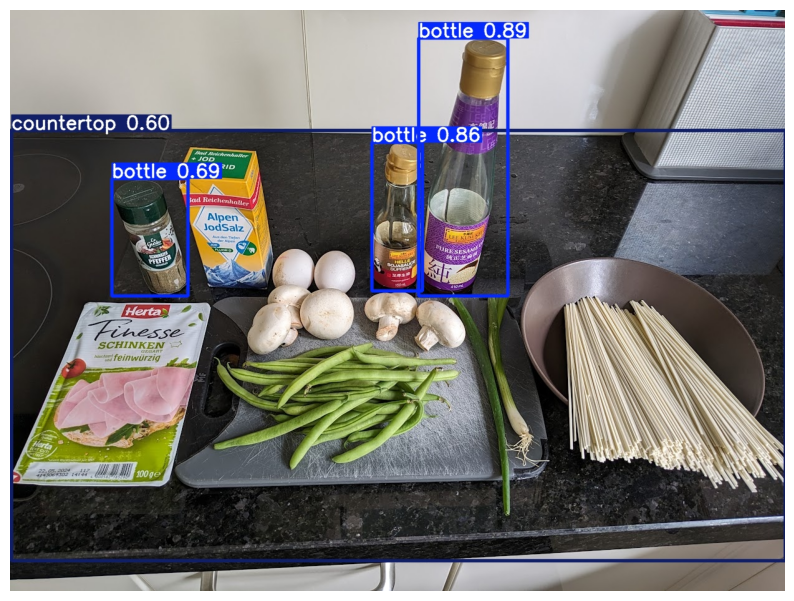

In [12]:
coco_label_list = coco_labels[0].split(",")
coco_label_list = [label.strip() for label in coco_label_list] 

res, metrics = yolo_model.predict(pred_classes=coco_label_list, image_path=image_path)
pretty_print("results", res)
pretty_print("results.bboxes", res.boxes)
pretty_print("metrics", metrics.__str__)

path = "tmp/yolo8world_try.jpg"
save_1 = yolo_model.save(path)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(path))

## GroundingDINO

In [13]:
import torch
from PIL import Image
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

import numpy as np
import supervision as sv


class GroundingDINO(OpenVocModel):
    box_threshold: float = 0.32
    text_threshold: float = 0.32
    _image: Image.Image
    _res: Any
    _pred_classes: list[str]
    _is_tiny: bool = False

    def __init__(self, is_tiny: bool = False):
        self._is_tiny = is_tiny

    def predict(
        self,
        image_path: str,
        pred_classes: list[str],
    ) -> tuple[Any, Metrics]:
        self._image = Image.open(image_path)
        caption = ". ".join(pred_classes) + "." if pred_classes else ""
        model_id = "IDEA-Research/grounding-dino-base" if not self._is_tiny else "IDEA-Research/grounding-dino-tiny"
        device = "cuda" if torch.cuda.is_available() else "cpu"
        processor = AutoProcessor.from_pretrained(model_id)
        model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        inputs = processor(
            images=self._image,
            text=caption,
            return_tensors="pt",
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            results = processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=self.box_threshold,
                text_threshold=self.text_threshold,
                target_sizes=[self._image.size[::-1]],
            )
            ret = results[0]
            self._res = ret
            self._pred_classes = pred_classes
            return ret, Metrics(pred_classes, ret["labels"])

    def save(self, path: str):
        res_labels = self._res["labels"]

        def class2id(classes: list[str], res_labels: list[str]) -> np.ndarray:
            return np.array([classes.index(label) for label in res_labels])

        confidence = self._res["scores"].cpu().detach().numpy()
        detections = sv.Detections(
            xyxy=self._res["boxes"].cpu().detach().numpy(),
            confidence=confidence,
            class_id=class2id(self._pred_classes, res_labels),
        )
        bbox_annotator, label_annotator = sv.BoundingBoxAnnotator(
            color=sv.ColorPalette.ROBOFLOW
        ), sv.LabelAnnotator(color=sv.ColorPalette.ROBOFLOW)
        annotated_image = label_annotator.annotate(
            bbox_annotator.annotate(
                self._image.copy(),
                detections=detections,
                custom_color_lookup=sv.ColorLookup.CLASS,
            ),
            detections=detections,
            labels=[
                label + " " + str(round(score, 2))
                for label, score in zip(res_labels, confidence)
            ],
            custom_color_lookup=sv.ColorLookup.CLASS,
        )
        annotated_image.save(path)
        return path
    
grounding_dino = GroundingDINO()
grounding_dino_tiny = GroundingDINO(is_tiny=True)

c:\Users\I804028\AppData\Local\miniconda3\envs\machinelearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Try

results


{
│   'scores': tensor([0.5986, 0.6929, 0.5889, 0.4807, 0.3900, 0.3306, 0.3417, 0.3349, 0.3713], device='cuda:0'),
│   'labels': ['bottle', 'countertop', 'bottle', 'bottle', 'label', 'label', 'label', 'oil', 'oil'],
│   'boxes': tensor([[ 656.4734,   46.9650,  798.3817,  462.4239],
│   │   [   2.0621,  191.3457, 1240.5016,  913.0476],
│   │   [ 578.7360,  213.1779,  663.7401,  462.3406],
│   │   [ 165.1584,  271.7630,  286.8348,  458.7496],
│   │   [   1.3589,  466.8289,  322.2973,  767.0760],
│   │   [ 657.4931,  286.3237,  769.9148,  457.9473],
│   │   [ 268.7392,  220.4297,  424.0412,  448.7997],
│   │   [ 578.4952,  212.8885,  663.7975,  462.0812],
│   │   [ 656.4440,   46.8344,  798.1348,  462.0026]], device='cuda:0')
}

metrics


0.8

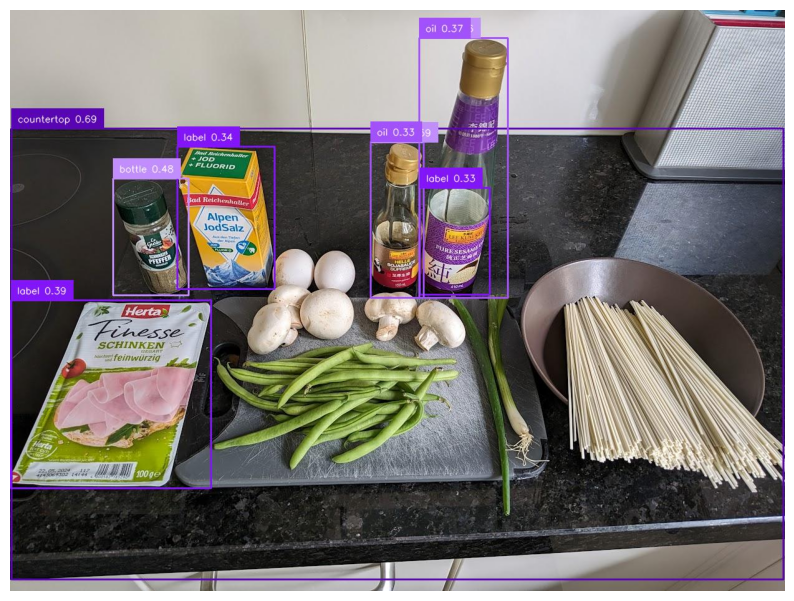

In [15]:
coco_label_list = coco_labels[0].split(",")
coco_label_list = [label.strip() for label in coco_label_list] 

res, metrics = grounding_dino_tiny.predict(
    image_path=image_path, pred_classes=coco_label_list
)
pretty_print("results", res)
pretty_print("metrics", metrics.accuracy())

path = "tmp/groundingDINO_try.jpg"
save_1 = grounding_dino_tiny.save(path)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(path))

## Survey

In [16]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [17]:
final_result_dict = dict()
final_result_dict["YOLOv8 World"] = list()
final_result_dict["GroundingDINO(Base)"] = list()
final_result_dict["GroundingDINO(Tiny)"] = list()


def do_survey(coco_label: str):
    coco_label_list = coco_label.split(",")
    coco_label_list = [label.strip() for label in coco_label_list]

    _, metrics = yolo_model.predict(pred_classes=coco_label_list, image_path=image_path)
    final_result_dict["YOLOv8 World"].append(metrics.accuracy())

    _, metrics = grounding_dino.predict(
        image_path=image_path, pred_classes=coco_label_list
    )
    final_result_dict["GroundingDINO(Base)"].append(metrics.accuracy())

    _, metrics = grounding_dino_tiny.predict(
        image_path=image_path, pred_classes=coco_label_list
    )
    final_result_dict["GroundingDINO(Tiny)"].append(metrics.accuracy())


# asyncio.run(asyncio.gather(*[do_survey(coco_label) for coco_label in coco_labels]))
for coco_label in coco_labels:
    do_survey(coco_label)


image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 bottles, 1 countertop, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 bottles, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 3 eggs, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 (no detections), 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms

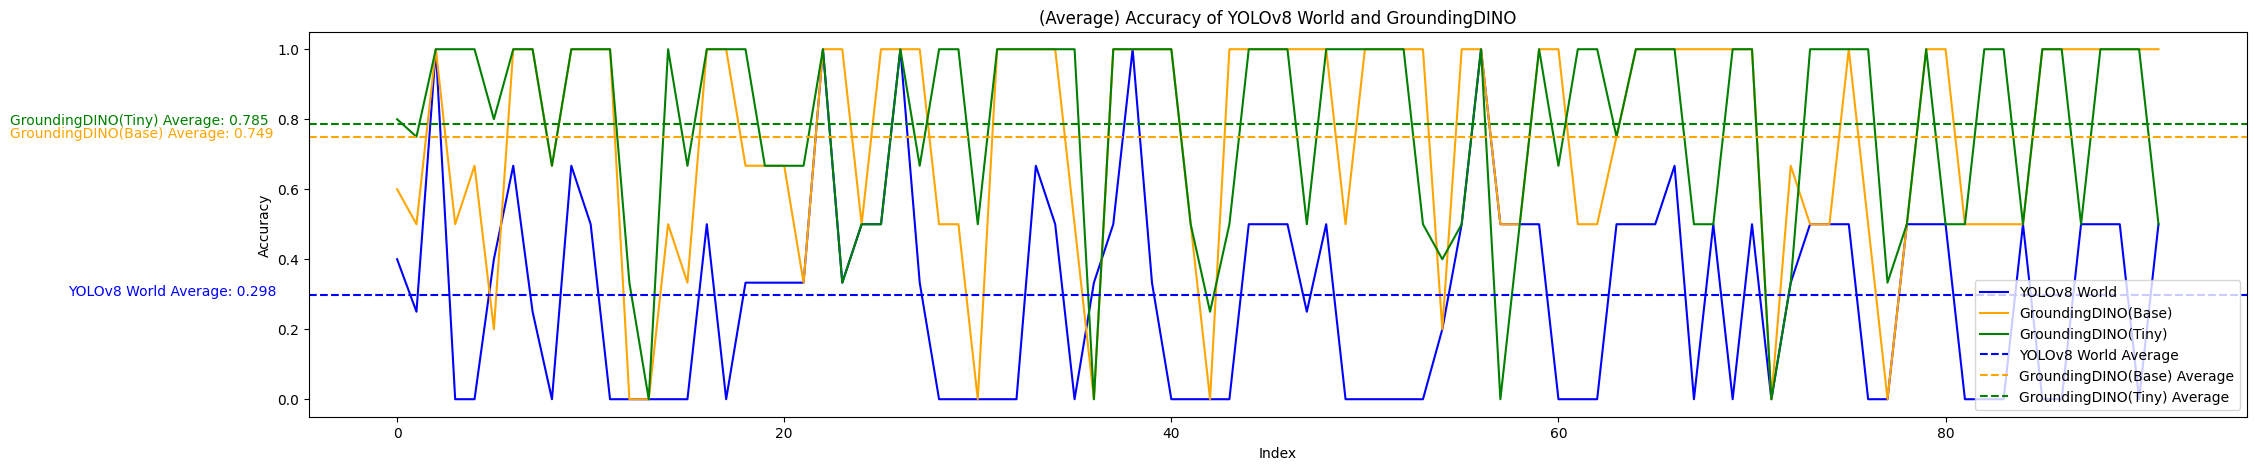

In [37]:
# plot the results

# average the results
average_result_dict = dict()
average_result_dict["YOLOv8 World"] = round(
    sum(final_result_dict["YOLOv8 World"]) / len(final_result_dict["YOLOv8 World"]), 3
)

average_result_dict["GroundingDINO(Base)"] = round(
    sum(final_result_dict["GroundingDINO(Base)"])
    / len(final_result_dict["GroundingDINO(Base)"]),
    3,
)

average_result_dict["GroundingDINO(Tiny)"] = round(
    sum(final_result_dict["GroundingDINO(Tiny)"])
    / len(final_result_dict["GroundingDINO(Tiny)"]),
    3,
)


plt.figure(figsize=(25, 5))

plt.plot(
    final_result_dict["YOLOv8 World"],
    color="blue",
    label="YOLOv8 World",
),
plt.plot(
    final_result_dict["GroundingDINO(Base)"],
    color="orange",
    label="GroundingDINO(Base)",
)
plt.plot(
    final_result_dict["GroundingDINO(Tiny)"],
    color="green",
    label="GroundingDINO(Tiny)",
)

plt.axhline(
    average_result_dict["YOLOv8 World"],
    color="blue",
    linestyle="--",
    label="YOLOv8 World Average",
)
plt.axhline(
    average_result_dict["GroundingDINO(Base)"],
    color="orange",
    linestyle="--",
    label="GroundingDINO(Base) Average",
)
plt.axhline(
    average_result_dict["GroundingDINO(Tiny)"],
    color="green",
    linestyle="--",
    label="GroundingDINO(Tiny) Average",
)

plt.text(
    -17,
    average_result_dict["YOLOv8 World"],
    f"YOLOv8 World Average: {average_result_dict['YOLOv8 World']}",
    color="blue",
)
plt.text(
    -20,
    average_result_dict["GroundingDINO(Base)"],
    f"GroundingDINO(Base) Average: {average_result_dict['GroundingDINO(Base)']}",
    color="orange",
)
plt.text(
    -20,
    average_result_dict["GroundingDINO(Tiny)"],
    f"GroundingDINO(Tiny) Average: {average_result_dict['GroundingDINO(Tiny)']}",
    color="green",
)
plt.title("(Average) Accuracy of YOLOv8 World and GroundingDINO")
plt.xlabel("Index")
plt.ylabel("Accuracy")

plt.legend()
plt.show()